In [21]:
import numpy as np
import matplotlib.pyplot as plt


In [27]:
#This is to make L shape

#-----vertical wall---------
wall_start_v = np.array([4,0])
wall_end_v = np.array([4,6])

#-----Horizontal wall------              
wall_start_h = np.array([4,6])
wall_end_h = np.array([8,6])

#combine
walls =[
    (wall_start_v , wall_end_v),
    (wall_start_h, wall_end_h)
]

# Start and Goal
start = np.array([1, 1])
goal  = np.array([9, 9])

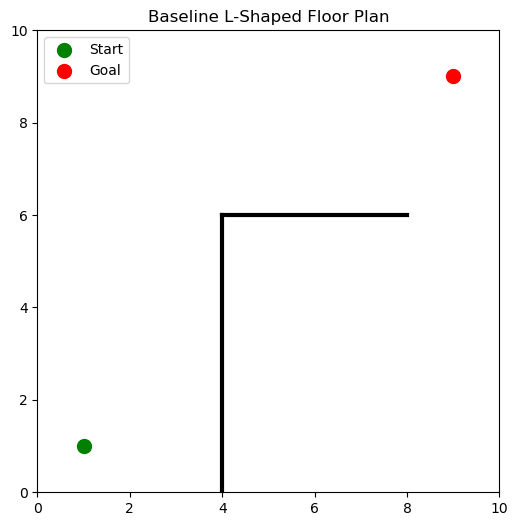

In [29]:
plt.figure(figsize=(6,6))

# Draw walls
for (a, b) in walls:
    plt.plot([a[0], b[0]], [a[1], b[1]], 'k-', linewidth=3)

# Draw start and goal
plt.scatter(start[0], start[1], color='green', s=100, label='Start')
plt.scatter(goal[0], goal[1], color='red', s=100, label='Goal')

plt.gca().set_aspect('equal')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.legend()

plt.title("Baseline L-Shaped Floor Plan")
plt.show()

In [31]:
def point_segment_distance(x, a, b):
    """
    Minimum Euclidean distance from point x to the segment from a to b.
    (Listing 3.1 in the assignment PDF)
    """
    x = np.asarray(x, dtype=float)
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)

    v = b - a
    w = x - a
    vv = np.dot(v, v)

    # Degenerate case: a and b are the same point
    if vv == 0.0:
        return np.linalg.norm(x - a)

    t = np.dot(w, v) / vv
    t = np.clip(t, 0.0, 1.0)

    q = a + t * v
    return np.linalg.norm(x - q)

In [33]:
test_point = np.array([5.0, 2.0])

for i, (a, b) in enumerate(walls, start=1):
    d = point_segment_distance(test_point, a, b)
    print(f"Distance from test_point to wall {i}: {d:.4f}")


Distance from test_point to wall 1: 1.0000
Distance from test_point to wall 2: 4.0000


In [35]:
def C_goal(x, goal):
    # Simple quadratic attraction
    return 0.5 * np.sum((x - goal)**2)

In [37]:
def phi_quadratic_band(d, R):
    #0 if far from wall, quadratic penalty if within R
    if d > R:
        return 0.0
    return 0.5 * (R - d)**2

In [39]:
def C_walls(x, walls, w_wall, R):
    total = 0.0
    for (a, b) in walls:
        d = point_segment_distance(x, a, b)
        total += w_wall * phi_quadratic_band(d, R)
    return total


In [41]:
def C_total(x, goal, walls, w_wall, R):
    return C_goal(x, goal) + C_walls(x, walls, w_wall, R)

In [43]:
R = 2.0 # influence radius
w_wall = 50.0 # wall weight

print("C_total at start:", C_total(start, goal, walls, w_wall, R))
print("C_total near wall:", C_total(np.array([4.2, 2.0]), goal, walls, w_wall, R))
print("C_total far from wall:", C_total(np.array([9.0, 1.0]), goal, walls, w_wall, R))

C_total at start: 64.0
C_total near wall: 117.01999999999998
C_total far from wall: 32.0


In [45]:
def numerical_gradient(C_func, x, h=1e-4):
    """
    Numerical gradient of a scalar function C_func at point x in R^2.
    Uses central differences.
    """
    x = np.asarray(x, dtype=float)
    grad = np.zeros_like(x)

    for i in range(len(x)):
        x_forward = x.copy()
        x_backward = x.copy()
        x_forward[i] += h
        x_backward[i] -= h
        grad[i] = (C_func(x_forward) - C_func(x_backward)) / (2*h)

    return grad

In [47]:
def run_gradient_descent(start, goal, walls, w_wall, R, alpha=0.05, max_iters=5000, tol=0.1):
    """
    Moves a point from start toward goal by descending the gradient of total cost.
    Returns a list of positions (trajectory).
    """

    # Wrap C_total so numerical_gradient only needs x
    def C_wrapped(x):
        return C_total(x, goal, walls, w_wall, R)

    x = start.astype(float).copy()
    trajectory = [x.copy()]

    for _ in range(max_iters):
        # Stop if close enough to goal
        if np.linalg.norm(x - goal) < tol:
            break

        grad = numerical_gradient(C_wrapped, x)

        # Gradient descent update
        x = x - alpha * grad
        trajectory.append(x.copy())

    return np.array(trajectory)


In [49]:
R = 2.0
w_wall = 50.0

traj = run_gradient_descent(start, goal, walls, w_wall, R, alpha=0.05, max_iters=2000, tol=0.1)
print("Trajectory length:", len(traj))
print("Final position:", traj[-1])
print("Distance to goal:", np.linalg.norm(traj[-1] - goal))


Trajectory length: 112
Final position: [8.90642046 8.98253801]
Distance to goal: 0.0951948103933583


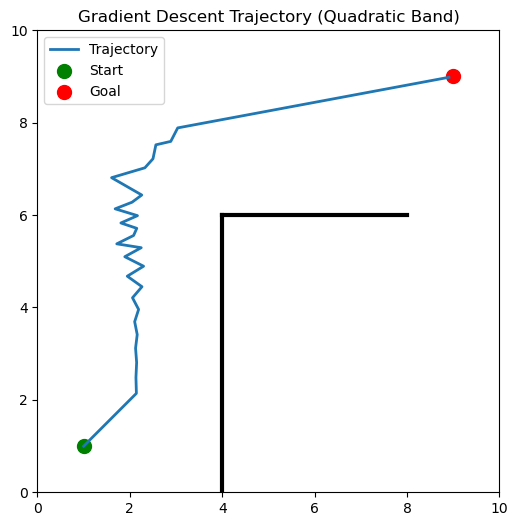

In [51]:
plt.figure(figsize=(6,6))

# Draw walls
for (a, b) in walls:
    plt.plot([a[0], b[0]], [a[1], b[1]], 'k-', linewidth=3)

# Draw trajectory
plt.plot(traj[:,0], traj[:,1], '-', linewidth=2, label='Trajectory')

# Start and goal
plt.scatter(start[0], start[1], color='green', s=100, label='Start')
plt.scatter(goal[0], goal[1], color='red', s=100, label='Goal')

plt.gca().set_aspect('equal')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.legend()
plt.title("Gradient Descent Trajectory (Quadratic Band)")
plt.show()


In [53]:
# Grid settings 
x_min, x_max = 0, 10
y_min, y_max = 0, 10
N = 60 # increase for smoother plots (slower)

xs = np.linspace(x_min, x_max, N)
ys = np.linspace(y_min, y_max, N)
X, Y = np.meshgrid(xs, ys)

R = 2.0
w_wall = 50.0

Z = np.zeros_like(X)

for i in range(N):
    for j in range(N):
        x = np.array([X[i, j], Y[i, j]])
        Z[i, j] = C_total(x, goal, walls, w_wall, R)

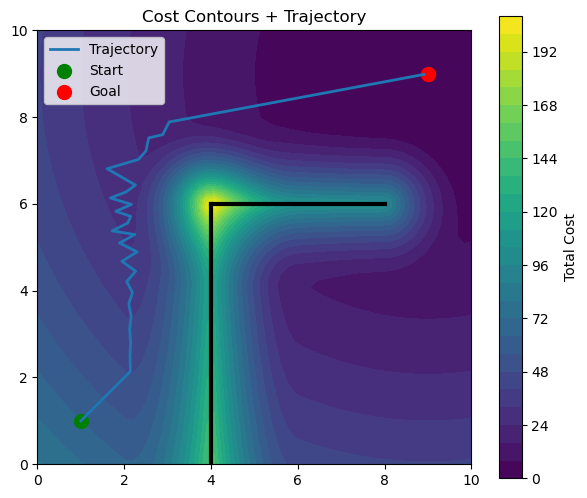

In [55]:
plt.figure(figsize=(7,6))
plt.contourf(X, Y, Z, levels=30)
plt.colorbar(label="Total Cost")

#Walls
for (a, b) in walls:
    plt.plot([a[0], b[0]], [a[1], b[1]], 'k-', linewidth=3)

# Trajectory
plt.plot(traj[:,0], traj[:,1], '-', linewidth=2, label='Trajectory')

# Start/Goal
plt.scatter(start[0], start[1], color='green', s=100, label='Start')
plt.scatter(goal[0], goal[1], color='red', s=100, label='Goal')

plt.gca().set_aspect('equal')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.title("Cost Contours + Trajectory")
plt.show()

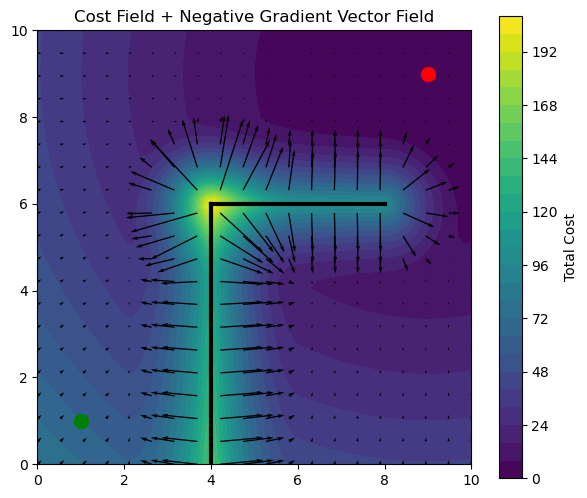

In [57]:
# Make a coarser grid for arrows (so it doesn't look too dense)
M = 20
xs2 = np.linspace(x_min, x_max, M)
ys2 = np.linspace(y_min, y_max, M)
X2, Y2 = np.meshgrid(xs2, ys2)

U = np.zeros_like(X2)
V = np.zeros_like(Y2)

def C_wrapped(x):
    return C_total(x, goal, walls, w_wall, R)

for i in range(M):
    for j in range(M):
        x = np.array([X2[i, j], Y2[i, j]])
        g = numerical_gradient(C_wrapped, x)
        U[i, j] = -g[0]
        V[i, j] = -g[1]

plt.figure(figsize=(7,6))
plt.contourf(X, Y, Z, levels=30)
plt.colorbar(label="Total Cost")

plt.quiver(X2, Y2, U, V)

for (a, b) in walls:
    plt.plot([a[0], b[0]], [a[1], b[1]], 'k-', linewidth=3)

plt.scatter(start[0], start[1], color='green', s=100, label='Start')
plt.scatter(goal[0], goal[1], color='red', s=100, label='Goal')

plt.gca().set_aspect('equal')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title("Cost Field + Negative Gradient Vector Field")
plt.show()

In [59]:
def phi_quartic_band(d, R):
    if d > R:
        return 0.0
    return (R - d)**4

In [61]:
def phi_log_barrier(d, R, eps=1e-3):
    if d > R:
        return 0.0
    return np.log(R / (d + eps))

In [63]:
def C_walls_generic(x, walls, w_wall, penalty_func):
    total = 0.0
    for (a, b) in walls:
        d = point_segment_distance(x, a, b)
        total += w_wall * penalty_func(d)
    return total

def C_total_generic(x, goal, walls, w_wall, penalty_func):
    return C_goal(x, goal) + C_walls_generic(x, walls, w_wall, penalty_func)

In [65]:
def run_gradient_descent_generic(start, goal, walls, w_wall, penalty_func,
                                alpha=0.05, max_iters=2000, tol=0.1):
    def C_wrapped(x):
        return C_total_generic(x, goal, walls, w_wall, penalty_func)

    x = start.astype(float).copy()
    trajectory = [x.copy()]

    for _ in range(max_iters):
        if np.linalg.norm(x - goal) < tol:
            break

        grad = numerical_gradient(C_wrapped, x)
        x = x - alpha * grad
        trajectory.append(x.copy())

    return np.array(trajectory)

In [67]:
R = 2.0
eps = 1e-3

def penalty_quadratic(d):
    if d > R:
        return 0.0
    return 0.5 * (R - d)**2

def penalty_quartic(d):
    if d > R:
        return 0.0
    return (R - d)**4

def penalty_log(d):
    if d > R:
        return 0.0
    return np.log(R / (d + eps))

In [69]:
w_wall = 50.0
alpha = 0.05

traj_quad = run_gradient_descent_generic(start, goal, walls, w_wall, penalty_quadratic, alpha=alpha)
traj_quart = run_gradient_descent_generic(start, goal, walls, w_wall, penalty_quartic, alpha=alpha)
traj_log = run_gradient_descent_generic(start, goal, walls, w_wall, penalty_log, alpha=alpha)

print("Quadratic steps:", len(traj_quad), "final dist:", np.linalg.norm(traj_quad[-1] - goal))
print("Quartic steps:", len(traj_quart), "final dist:", np.linalg.norm(traj_quart[-1] - goal))
print("Log steps:", len(traj_log), "final dist:", np.linalg.norm(traj_log[-1] - goal))

Quadratic steps: 112 final dist: 0.0951948103933583
Quartic steps: 111 final dist: 0.09731296734984092
Log steps: 119 final dist: 0.09665296099723643


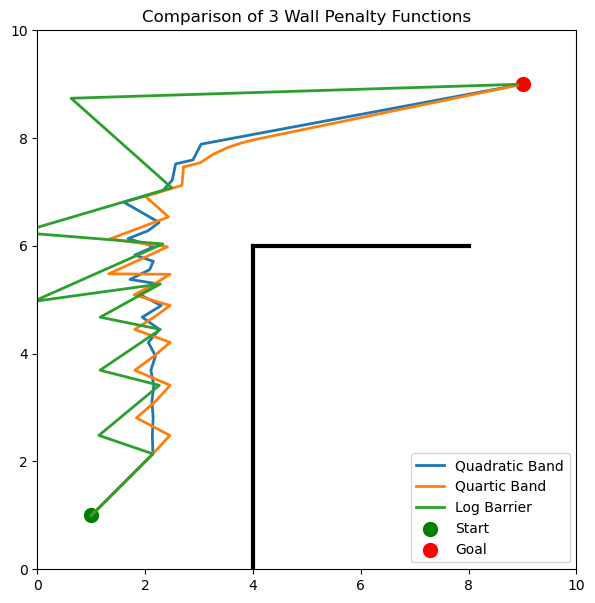

In [73]:
plt.figure(figsize=(7,7))

#Walls
for (a, b) in walls:
    plt.plot([a[0], b[0]], [a[1], b[1]], 'k-', linewidth=3)

# Trajectories
plt.plot(traj_quad[:,0], traj_quad[:,1], linewidth=2, label="Quadratic Band")
plt.plot(traj_quart[:,0], traj_quart[:,1], linewidth=2, label="Quartic Band")
plt.plot(traj_log[:,0], traj_log[:,1], linewidth=2, label="Log Barrier")

# Start/Goal
plt.scatter(start[0], start[1], color='green', s=100, label='Start')
plt.scatter(goal[0], goal[1], color='red', s=100, label='Goal')

plt.gca().set_aspect('equal')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.legend()
plt.title("Comparison of 3 Wall Penalty Functions")
plt.show()

In [75]:
# --- Choose penalty which to display ---
R = 2.0
eps = 1e-3
w_wall = 50.0

def penalty_quadratic(d):
    if d > R:
        return 0.0
    return 0.5 * (R - d)**2

# --- Build grid ---
x_min, x_max = 0, 10
y_min, y_max = 0, 10
N = 80 # higher = smoother, slower

xs = np.linspace(x_min, x_max, N)
ys = np.linspace(y_min, y_max, N)
X, Y = np.meshgrid(xs, ys)

# --- Compute total cost on grid ---
Z = np.zeros_like(X)

for i in range(N):
    for j in range(N):
        p = np.array([X[i, j], Y[i, j]])
        Z[i, j] = C_total_generic(p, goal, walls, w_wall, penalty_quadratic)

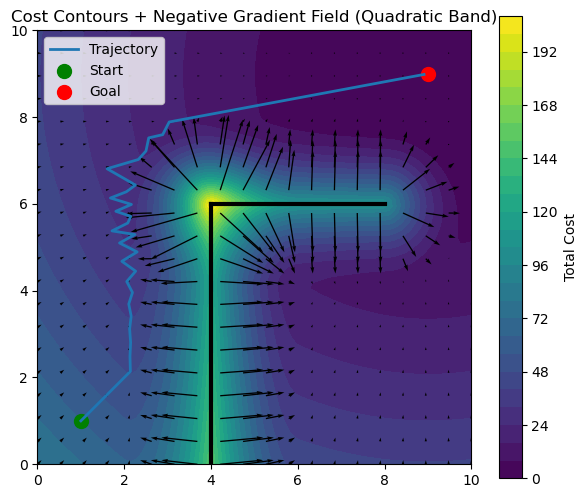

In [85]:
# --- Vector field grid (coarser so arrows look clean) ---
M = 20
xs2 = np.linspace(x_min, x_max, M)
ys2 = np.linspace(y_min, y_max, M)
X2, Y2 = np.meshgrid(xs2, ys2)

U = np.zeros_like(X2)
V = np.zeros_like(Y2)

def C_wrapped(x):
    return C_total_generic(x, goal, walls, w_wall, penalty_quadratic)

for i in range(M):
    for j in range(M):
        p = np.array([X2[i, j], Y2[i, j]])
        g = numerical_gradient(C_wrapped, p)
        U[i, j] = -g[0] # negative gradient
        V[i, j] = -g[1]

plt.figure(figsize=(7,6))

# Contours (total cost)
plt.contourf(X, Y, Z, levels=30)
plt.colorbar(label="Total Cost")

# Negative gradient field
plt.quiver(X2, Y2, U, V)

#Walls
for (a, b) in walls:
    plt.plot([a[0], b[0]], [a[1], b[1]], 'k-', linewidth=3)

# Trajectory (use your already-computed traje_quad if you have it)
# If not, uncomment next line to compute one quickly:
# traj_quad = run_gradient_descent_generic(start, goal, walls, w_wall, penalty_quadratic, alpha=0.05)

plt.plot(traj_quad[:,0], traj_quad[:,1], linewidth=2, label="Trajectory")

#Start/Goal
plt.scatter(start[0], start[1], color="green", s=100, label="Start")
plt.scatter(goal[0], goal[1], color="red", s=100, label="Goal")

plt.gca().set_aspect("equal")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.title("Cost Contours + Negative Gradient Field (Quadratic Band)")
plt.show()

# Analysis (Section 2.6)

## 1. How does wall thickness / influence radius affect the resulting path?

The influence radius R determines how far from a wall the penalty function begins to affect the motion of the point. When R is small, the wall only influences the point when it is very close, which causes the trajectory to approach the wall more tightly before turning away. This can make the motion look more direct but also less safe, since the path may touch the wall. When R is larger, the wall's influence extends further into the space, so the point begins adjusting its direction earlier. This results in smoother curves and greater clearance from the wall, but it can also make the path longer or more curved. Overall, increasing the influence radius makes the cost landscape broader around walls and changes how early the gradient descent responds to obstacles.

## 2. What happens near corners or narrow corridors?

Near corners, the point is affected by the gradients of multiple walls at the same time. Since the total cost is the sum of wall penalties and goal attraction, the combined gradients can create sharper turning behavior at the corner. Depending on the penalty function, this can look smooth or more aggressive and abrupt. In narrow corridors, the point feels competing repulsion from parallel walls. This can sometimes cause oscillation, especially if the penalty is strong or the step size is too large. The point may move slightly left and right while trying to balance between both walls. These behaviors demonstrate how multiple interacting gradients shape the motion in constrained spaces.

In [ ]:
## 3. Does the method ever get stuck? Why or why not?

Yes, the method can get stuck because gradient descent is a local optimization method. It only follows the direction of steepest descent and does not guarantee reaching the global minimum at the goal. If the wall penalties and goal attraction create a region where the gradient becomes very small or cancels out, the point can stop moving even if it has not reached the goal. This is especially likely in dead-end configurations or symmetric environments where forces from different directions balance each other. Since the motion is entirely determined by the cost function, poor parameter choices or certain map configurations can produce local minimum. This highlights one of the main limitations of potential-field methods.